In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier

# Get the data ready

I use some technique from this [notebook](https://www.kaggle.com/ihelon/titanic-hyperparameter-tuning-with-gridsearchcv)

In [2]:
train=pd.read_csv('../input/titanic/train.csv')
test=pd.read_csv('../input/titanic/test.csv')

full=pd.concat([train,test],ignore_index=True)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
full.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [4]:
full.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

There are so many null in Cabin, so I will drop it

In [5]:
full.drop(['Cabin'],axis=1,inplace=True)

Next I will fill in Fare value but I need to check Fare distribution first
I think Fare might relate to Pclass, so I plot a boxplot

<AxesSubplot:title={'center':'Fare'}, xlabel='Pclass'>

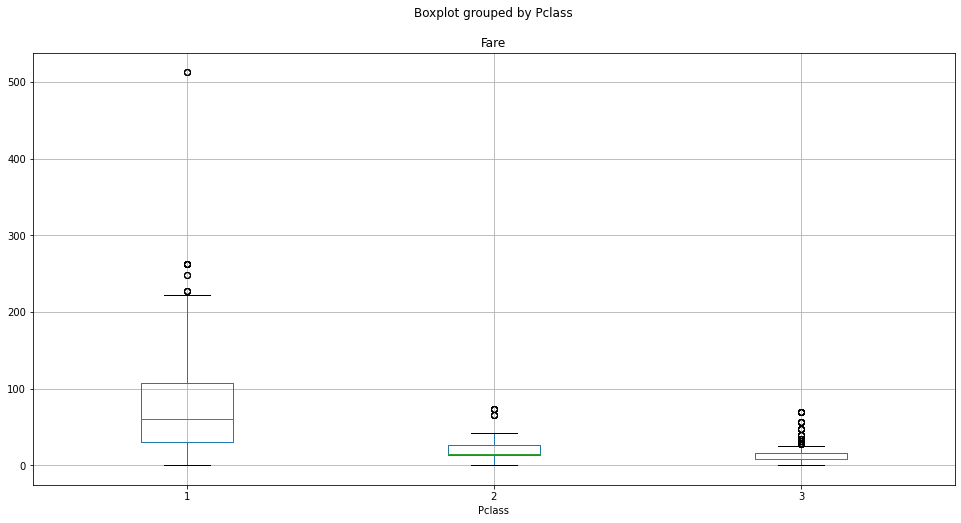

In [6]:
full.boxplot(column='Fare',by='Pclass',figsize=(16,8))

From boxplot Fare is very skew when I observed from green line, so median might be best choice to fill value

In [7]:
full[['Pclass','Fare']].groupby('Pclass').median()

,Fare
Pclass,
1,60.0000
2,15.0458
3,8.0500


In [8]:
full.loc[full.Fare.isnull(),:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


He is in class 3 and he is the only one who have missing value in Fare, so I fill Fare with 8.05

In [9]:
full.Fare.fillna(8.05, inplace=True)

full.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age            263
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64

Plot boxplot of Age by sex

<AxesSubplot:title={'center':'Age'}, xlabel='Sex'>

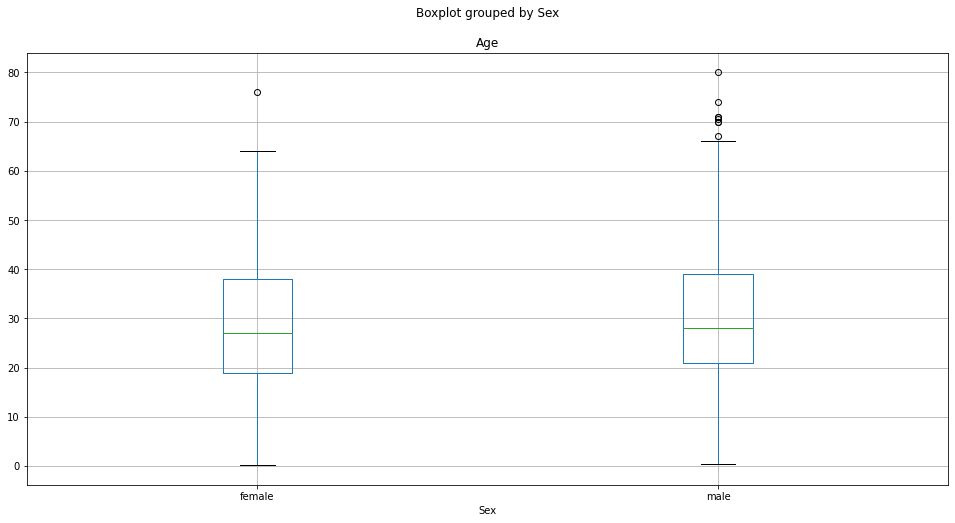

In [10]:
full.boxplot(column='Age',by='Sex',figsize=(16,8))

Plot boxplot of Age by Pclass

<AxesSubplot:title={'center':'Age'}, xlabel='Pclass'>

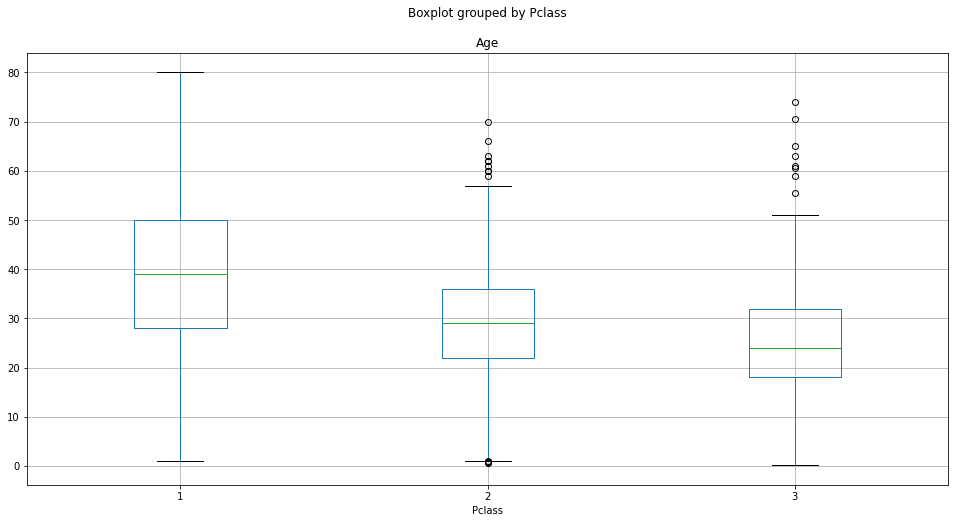

In [11]:
full.boxplot(column='Age',by='Pclass',figsize=(16,8))

I see difference of Age in each class, this might be useful information in which value should we fill in age column
In class 1 and class 2, it looklike normal distribution when I observe from green line
In class 3, it might be a little bit skew

So in conclude for people who in class 1 and class 2, I fill their age with mean

In class 3, I fill their age with median

In [12]:
Age_mean_median_by_Pclass=full[['Pclass','Age']].groupby('Pclass').aggregate(['mean','median'])
Age_mean_median_by_Pclass

Age       
             mean median
Pclass                  
1       39.159930   39.0
2       29.506705   29.0
3       24.816367   24.0

In [13]:
age_class1_fill=Age_mean_median_by_Pclass.iloc[0,0].round(2)
age_class2_fill=Age_mean_median_by_Pclass.iloc[1,0].round(2)
age_class3_fill=Age_mean_median_by_Pclass.iloc[2,1].round(2)

full.loc[full.Pclass==1,'Age']=full.loc[full.Pclass==1,'Age'].fillna(age_class1_fill)
full.loc[full.Pclass==2,'Age']=full.loc[full.Pclass==2,'Age'].fillna(age_class2_fill)
full.loc[full.Pclass==3,'Age']=full.loc[full.Pclass==3,'Age'].fillna(age_class3_fill)

full.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64

Explore embarked

In [14]:
full['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

Maybe mode is best choice to fill missing values in embarked

In [15]:
full['Embarked'].fillna('S',inplace=True)

full.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
dtype: int64

Extract ticket number and do a label encode

In [16]:
Ticket_num=full['Ticket'].str.split(' ').str[-1]
le = LabelEncoder()
Ticket_num=le.fit_transform(Ticket_num)
full['Ticket']=Ticket_num
full['Ticket']

0       209
1       166
2       466
3        67
4       832
       ... 
1304    533
1305    184
1306    446
1307    760
1308    370
Name: Ticket, Length: 1309, dtype: int64

Extract name title

In [17]:
first_name=full['Name'].str.split(',').str[1]
name_title=first_name.str.split(' ').str[1]

name_title=name_title.replace(["Ms.", "Mlle."], "Miss.")
name_title=name_title.replace(["Mme.", "the", "Lady.", "Dona."], "Mrs.")
name_title=name_title.replace(["Dr.", "Major.", "Col.", "Sir.", "Rev.", "Jonkheer.", "Capt.", "Don."], "Mr.")
full['Name_title']=name_title

full.drop('Name',axis=1,inplace=True)
full['Name_title']

0           Mr.
1          Mrs.
2         Miss.
3          Mrs.
4           Mr.
         ...   
1304        Mr.
1305       Mrs.
1306        Mr.
1307        Mr.
1308    Master.
Name: Name_title, Length: 1309, dtype: object

Convert string data to numberic data

In [18]:
Sex_map={'male':0,'female':1}
Embarked_map={'S':0,'C':1,'Q':2}
Name_title_map={'Mr.':0,'Mrs.':1,'Miss.':2,'Master.':3}
full['Sex']=full['Sex'].map(Sex_map)
full['Embarked']=full['Embarked'].map(Embarked_map)
full['Name_title']=full['Name_title'].map(Name_title_map)
full.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Name_title
0,1,0.0,3,0,22.0,1,0,209,7.2500,0,0
1,2,1.0,1,1,38.0,1,0,166,71.2833,1,1
2,3,1.0,3,1,26.0,0,0,466,7.9250,0,2
3,4,1.0,1,1,35.0,1,0,67,53.1000,0,1
4,5,0.0,3,0,35.0,0,0,832,8.0500,0,0


Add family size and normalize fare

In [19]:
full['Family_size']=full['SibSp']+full['Parch']

full.drop(['SibSp','Parch'],axis=1,inplace=True)

full['Fare']=(full['Fare']-full['Fare'].mean())/full['Fare'].std()
full['Fare']

full.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Name_title,Family_size
0,1,0.0,3,0,22.0,209,-0.502984,0,0,1
1,2,1.0,1,1,38.0,166,0.734528,1,1,1
2,3,1.0,3,1,26.0,466,-0.489939,0,2,0
3,4,1.0,1,1,35.0,67,0.383116,0,1,1
4,5,0.0,3,0,35.0,832,-0.487523,0,0,0


# Do machine learning

Split full into train and test and select predictor and target

In [20]:
train=full.loc[full['Survived'].notnull(),:]
test=full.loc[full['Survived'].isnull(),:].drop('Survived',axis=1)

X=train.drop(['PassengerId','Survived'],axis=1)
y=train['Survived']

X_test=test.drop('PassengerId',axis=1)

## RandomForest

In [21]:
model_RF=RandomForestClassifier(n_estimators=250,class_weight="balanced")
param_grid={'max_features':['auto', 'sqrt', 'log2']}
grid_RF=GridSearchCV(model_RF,param_grid,cv=5)

grid_RF.fit(X,y);

print('best_score=',grid_RF.best_score_)

best_model_RF=grid_RF.best_estimator_
y_predict_RF=best_model_RF.predict(X_test)

best_score= 0.8451133011110414


## LogisticRegression

In [22]:
model_LR=LogisticRegression(class_weight="balanced",solver="liblinear",)
param_grid={"C": [0.001, 0.01, 0.1, 1.],"penalty": ["l1", "l2"]}
grid_LR=GridSearchCV(model_LR,param_grid,cv=5)

grid_LR.fit(X,y);

print('best_score=',grid_LR.best_score_)

best_model_LR=grid_LR.best_estimator_
y_predict_LR=best_model_LR.predict(X_test)

best_score= 0.8024543343167411


## SVC

In [23]:
model_svc = SVC(kernel='linear',class_weight='balanced',probability=True)
param_grid = {'C': [0.001, 0.01, 0.1, 1.]}
grid_svc = GridSearchCV(model_svc, param_grid, cv=5)

grid_svc.fit(X,y);

print('best_score=',grid_svc.best_score_)

best_model_svc=grid_svc.best_estimator_
y_predict_svc=best_model_svc.predict(X_test)

best_score= 0.8148076078086749


## AdaBoostClassifier

In [24]:
model_ADA=AdaBoostClassifier()
param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1.]}
grid_ADA = GridSearchCV(model_ADA, param_grid, cv=5)

grid_ADA.fit(X,y);

print('best_score=',grid_ADA.best_score_)

best_model_ADA=grid_ADA.best_estimator_
y_predict_ADA=best_model_ADA.predict(X_test)

best_score= 0.8316238779737619


## CatBoost

In [25]:
cat_features = [0, 1]
model_cat=CatBoostClassifier(verbose=False)
param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1.]}
grid_cat = GridSearchCV(model_cat, param_grid, cv=5)

grid_cat.fit(X,y);

print('best_score=',grid_cat.best_score_)

best_model_cat=grid_cat.best_estimator_
y_predict_cat=best_model_cat.predict(X_test)

best_score= 0.8462431736865232


## Neural Network

Prepare data for neural network

In [26]:
X_neural=X.values
y_neural=to_categorical(y)
X_test_neural=X_test.values

### Experiment with neural network

I adapt neural network structure from this [notebook](https://www.kaggle.com/jamesleslie/titanic-neural-network-for-beginners#3.-Neural-Network)

In [27]:
def create_model(layers=[10],activation='relu',drop=0,optimizer='adam'):
    np.random.seed(42)
    tf.random.set_seed(42)
    
    model=Sequential()
    model.add(Dense(layers[0],activation=activation,input_shape=(X_neural.shape[1],)))
    
    if len(layers)>1:
        for layer in layers[1:]:
            model.add(Dense(layer,activation=activation))
            
    model.add(Dropout(drop))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    
    return model
    
model=create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                90        
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
Total params: 112
Trainable params: 112
Non-trainable params: 0
_________________________________________________________________


In [28]:
def test_model(layers=[10],activation='relu',drop=0,optimizer='adam',epochs=50):
    
    accuracy_array=[]
    
    for cross_val in range(5): #cross validation 5 times
        X_test_val=X_neural[int(round(cross_val*X.shape[0]/5,0)):int(round((cross_val+1)*X.shape[0]/5,0))]
        y_test_val=y_neural[int(round(cross_val*X.shape[0]/5,0)):int(round((cross_val+1)*X.shape[0]/5,0))]
        
        if cross_val==0:
            X_train_val=X_neural[int(round((cross_val+1)*X.shape[0]/5,0)):]
            y_train_val=y_neural[int(round((cross_val+1)*X.shape[0]/5,0)):]
        
        elif cross_val==4:
            X_train_val=X_neural[:int(round(cross_val*X.shape[0]/5,0))]
            y_train_val=y_neural[:int(round(cross_val*X.shape[0]/5,0))]
            
        else:
            X_train_part_one=X_neural[:int(round(cross_val*X.shape[0]/5,0))]
            X_train_part_two=X_neural[int(round((cross_val+1)*X.shape[0]/5,0)):]
            X_train_val=np.concatenate([X_train_part_one,X_train_part_two],axis=0)
            
            y_train_part_one=y_neural[:int(round(cross_val*X.shape[0]/5,0))]
            y_train_part_two=y_neural[int(round((cross_val+1)*X.shape[0]/5,0)):]
            y_train_val=np.concatenate([y_train_part_one,y_train_part_two],axis=0)
        
        model=create_model(layers=layers,activation=activation,drop=drop,optimizer=optimizer)
        history=model.fit(X_train_val,y_train_val,epochs=epochs,verbose=False)
        accuracy=history.history['accuracy'][-1]
        accuracy_array.append(accuracy)
    
    accuracy_array=np.array(accuracy_array)
    accuracy_mean=accuracy_array.mean()
    print('accuracy=',round(accuracy_mean*100,2),'%')

test_model()

accuracy= 76.68 %


#### Manual adjust model capacity

In [29]:
test_model([10])
test_model([20])
test_model([30])
test_model([40])
test_model([50])
test_model([60])
test_model([70])
test_model([80])
test_model([90])
test_model([100])

accuracy= 76.68 %
accuracy= 79.77 %
accuracy= 80.11 %
accuracy= 80.19 %
accuracy= 80.78 %
accuracy= 80.81 %
accuracy= 80.53 %
accuracy= 80.42 %
accuracy= 80.25 %
accuracy= 80.95 %


In [30]:
test_model([90])
test_model([95])
test_model([100])
test_model([105])
test_model([110])

accuracy= 80.25 %
accuracy= 80.3 %
accuracy= 80.95 %
accuracy= 80.81 %
accuracy= 80.53 %


Try adding another layer

In [31]:
test_model([100,10])
test_model([100,20])
test_model([100,30])
test_model([100,40])
test_model([100,50])
test_model([100,60])
test_model([100,70])
test_model([100,80])
test_model([100,90])
test_model([100,100])

accuracy= 67.26 %
accuracy= 81.71 %
accuracy= 80.36 %
accuracy= 80.36 %
accuracy= 81.12 %
accuracy= 80.95 %
accuracy= 80.61 %
accuracy= 80.84 %
accuracy= 80.5 %
accuracy= 80.05 %


In [32]:
test_model([100,15])
test_model([100,20])
test_model([100,25])

accuracy= 80.16 %
accuracy= 81.71 %
accuracy= 81.31 %


#### Manual adjust activation function

In [33]:
test_model(layers=[100,20],activation='relu')
test_model(layers=[100,20],activation='selu')
test_model(layers=[100,20],activation='tanh')
test_model(layers=[100,20],activation='sigmoid')
test_model(layers=[100,20],activation='softmax')
test_model(layers=[100,20],activation='softplus')
test_model(layers=[100,20],activation='softsign')
test_model(layers=[100,20],activation='elu')
test_model(layers=[100,20],activation='exponential')

accuracy= 81.71 %
accuracy= 81.2 %
accuracy= 82.77 %
accuracy= 82.3 %
accuracy= 81.26 %
accuracy= 81.31 %
accuracy= 82.66 %
accuracy= 81.03 %
accuracy= 61.62 %


#### Manual adjust dropout layer

In [34]:
test_model(layers=[100,20],activation='tanh',drop=0)
test_model(layers=[100,20],activation='tanh',drop=0.1)
test_model(layers=[100,20],activation='tanh',drop=0.2)
test_model(layers=[100,20],activation='tanh',drop=0.3)
test_model(layers=[100,20],activation='tanh',drop=0.4)
test_model(layers=[100,20],activation='tanh',drop=0.5)

accuracy= 82.77 %
accuracy= 83.02 %
accuracy= 82.41 %
accuracy= 82.24 %
accuracy= 81.99 %
accuracy= 82.04 %


In [35]:
test_model(layers=[100,20],activation='tanh',drop=0.05)
test_model(layers=[100,20],activation='tanh',drop=0.1)
test_model(layers=[100,20],activation='tanh',drop=0.15)

accuracy= 83.08 %
accuracy= 83.02 %
accuracy= 82.91 %


In [36]:
test_model(layers=[100,20],activation='tanh',drop=0.04)
test_model(layers=[100,20],activation='tanh',drop=0.05)
test_model(layers=[100,20],activation='tanh',drop=0.06)

accuracy= 83.17 %
accuracy= 83.08 %
accuracy= 82.66 %


I'm satisfy with accuracy of dropout 4% provide so I stop digging further

#### Manual adjust optimizer

In [37]:
test_model(layers=[100,20],activation='tanh',drop=0.04,optimizer='adam')
test_model(layers=[100,20],activation='tanh',drop=0.04,optimizer='sgd')
test_model(layers=[100,20],activation='tanh',drop=0.04,optimizer='RMSprop')
test_model(layers=[100,20],activation='tanh',drop=0.04,optimizer='Adagrad')
test_model(layers=[100,20],activation='tanh',drop=0.04,optimizer='Adadelta')
test_model(layers=[100,20],activation='tanh',drop=0.04,optimizer='Nadam')

accuracy= 83.17 %
accuracy= 63.8 %
accuracy= 81.73 %
accuracy= 65.6 %
accuracy= 61.64 %
accuracy= 83.17 %


#### Manual adjust epochs

In [38]:
test_model(layers=[100,20],activation='tanh',drop=0.04,optimizer='adam',epochs=50)
test_model(layers=[100,20],activation='tanh',drop=0.04,optimizer='adam',epochs=100)
test_model(layers=[100,20],activation='tanh',drop=0.04,optimizer='adam',epochs=150)
test_model(layers=[100,20],activation='tanh',drop=0.04,optimizer='adam',epochs=200)
test_model(layers=[100,20],activation='tanh',drop=0.04,optimizer='adam',epochs=250)
test_model(layers=[100,20],activation='tanh',drop=0.04,optimizer='adam',epochs=300)

accuracy= 83.17 %
accuracy= 83.08 %
accuracy= 84.12 %
accuracy= 84.2 %
accuracy= 85.41 %
accuracy= 85.19 %


Adding more epochs might yield better result but cost more training time so I choose 250 epochs

## Predict

In [39]:
model=create_model(layers=[100,20],activation='tanh',drop=0.04,optimizer='adam')
model.fit(X_neural,y_neural,epochs=250,verbose=False)
y_predict_neural=model.predict(X_test_neural)
y_predict_neural[:10]

array([[0.9907224 , 0.00927757],
       [0.6243081 , 0.37569192],
       [0.9853769 , 0.01462312],
       [0.99021614, 0.00978385],
       [0.5818284 , 0.41817155],
       [0.9931545 , 0.00684545],
       [0.2232385 , 0.77676153],
       [0.98407483, 0.01592513],
       [0.26372197, 0.73627806],
       [0.99520326, 0.0047967 ]], dtype=float32)

Choose location with most proability

In [40]:
y_predict_neural=np.array(y_predict_neural).argmax(axis=1)
y_predict_neural

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,

## Stacking

To avoid equal vote, I will remove least accuracy model which is logistic regression

In [41]:
result_df=pd.DataFrame({'RF':y_predict_RF,'SVC':y_predict_svc,'ADA':y_predict_ADA,'CAT':y_predict_cat,'NN':y_predict_neural})
vote_df=result_df.mode(axis=1)
vote_df

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,1.0
...,...
413,0.0
414,1.0
415,0.0
416,0.0


# Submit

In [42]:
PassengerId_df=pd.DataFrame({'PassengerId':test.index+1})
submission_df=pd.concat([PassengerId_df,vote_df.astype(int)],axis=1)
submission_df=submission_df.rename({0:'Survived'},axis=1)
submission_df=submission_df.set_index('PassengerId')
submission_df.to_csv('submission.csv')